In [2]:
library(dplyr)
library(rio) #great for exporting, importing
library (stringr)
library(cowplot)
library(ggplot2)
library(tidyr)
library(ggpubr)

library(patchwork)
library(RColorBrewer)
library(viridis)

In [3]:
# Import starch gene list
#:::::::::::::::::::::::::::::::::::
StarchGenes<- import(file = './Results/Carbohydrate_DM_Genes_FuncAnnot.csv',
                                sep =',',header = TRUE, fill = TRUE )

In [4]:
StarchGenes[1:2,]

,v6.1_geneID,v6.1_description,Syntelog,Enzyme
,<chr>,<chr>,<chr>,<chr>
1,Soltu.DM.01G002430,Sucrose-6F-phosphate phosphohydrolase family protein/Sucrose-6F-phosphate phosphohydrolase family protein,Synt_161,
2,Soltu.DM.01G002440,Sucrose-6F-phosphate phosphohydrolase family protein,Synt_162,


## Import gene expression datasets


In [5]:
CHC <- import(
       '../01_Data_normalization/Results/CHC_diel_leaf_avsd_expressed.csv', sep = ',', header =TRUE)
CND <- import(
       '../01_Data_normalization/Results/CND_diel_leaf_avsd_expressed.csv', sep = ',', header =TRUE)
ATL <- import(
       '../01_Data_normalization/Results/ATL_diel_leaf_avsd_expressed.csv', sep = ',', header =TRUE)

In [6]:
# combine dataframes
#:::::::::::::::::::::::::::
nrow(ATL)
SDLD <- rbind(CHC, CND, ATL)
nrow(SDLD)

[1] 2793297

[1] 4463927

In [7]:
SDLD[1:2,]

,geneID,ZT,Tissue,Condition,mean_expression,std,target_id,Genotype
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Solch.M6.01G000010.3,0,Leaf,LD,6.814213,0.2254201,Solch.M6.01G000010,CHC
2,Solch.M6.01G000010.3,0,Leaf,SD,6.860834,0.2677401,Solch.M6.01G000010,CHC


# Get syntelogs 

In [8]:

#::::::::::::::::::::::::::

#Get file that includes transcript version. Using Ann's syntelog list should contain most genes

SYN<- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/GeneLists/Syntelogs_Ann/syntelogs_atl0to4.csv', sep =',', header = TRUE, fill = TRUE )


In [9]:
SYN[1:2,]

,Syntelog,geneID
,<chr>,<chr>
1,Synt_0,Soltu.DM.01G000010.5
2,Synt_0,Solca.01G000010.5


In [10]:


### Add syntelog information 
# Make a target_id column 

SYN <- SYN %>% mutate(target_id = geneID)

#Remove transcript information from SYN$target_id

## REMOVE transcript version for versions from .1-.99 

SYN$target_id<-lapply(SYN$target_id,
                             function (i){if (str_sub(i,-2,-2) == ".")
                                             { i<- str_sub(i, end = -3)} # i.e. the last character will be -3 position
                                          else if ((str_sub(i,-3,-3) == "."))
                                               { i<- str_sub(i, end = -4)} # i.e. the last character will be -4 position
                                        else {i<-i}
                                          
                                        })


SYN$target_id <- as.character(SYN$target_id)
SYN[1:2,]

,Syntelog,geneID,target_id
,<chr>,<chr>,<chr>
1,Synt_0,Soltu.DM.01G000010.5,Soltu.DM.01G000010
2,Synt_0,Solca.01G000010.5,Solca.01G000010


In [11]:
## Add genome name

SYNg<- SYN %>% mutate(Genome=
                     case_when(str_detect(geneID,'Solca') ~ 'CND',
                              str_detect(geneID,'M6') ~ 'CHC',
                              str_detect(geneID,'DM') ~ 'DM',
                              str_detect(geneID,'Atl.*_1G') ~ 'ATL_H1',
                              str_detect(geneID,'Atl.*_2G') ~ 'ATL_H2',
                              str_detect(geneID,'Atl.*_3G') ~ 'ATL_H3',
                              str_detect(geneID,'Atl.*_4G') ~ 'ATL_H4',
                              str_detect(geneID,'Atl.*_0G') ~ 'ATL_H0',
                              str_detect(geneID,'Atl.*S') ~ 'ATL_S0'))



# Add syntelog to expression data

In [13]:
SDLDs <- SDLD %>% left_join(SYNg %>% select(-geneID), by ='target_id')

In [14]:
SDLDs [1:2,]

,geneID,ZT,Tissue,Condition,mean_expression,std,target_id,Genotype,Syntelog,Genome
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,Solch.M6.01G000010.3,0,Leaf,LD,6.814213,0.2254201,Solch.M6.01G000010,CHC,NA,NA
2,Solch.M6.01G000010.3,0,Leaf,SD,6.860834,0.2677401,Solch.M6.01G000010,CHC,NA,NA


# Get expression of only starch related genes

In [15]:
SDLD_starch <- SDLDs %>% filter(Syntelog %in% StarchGenes$Syntelog)
nrow(SDLD_starch)

[1] 14872

# Define plot functions

In [17]:
#Defining ribbon SD plot 
SD_ribbon_plot_multiple <- function(df,columns) {

plot_cho <- df %>%
  ggplot(.,aes(x=ZT,y=mean_expression,col=Genome))+ # this means that all colors below are determined by Genome
    geom_rect(aes(xmin= 12,
                  xmax = 24,
                  ymin = -Inf,
                  ymax = Inf), 
                 fill = 'grey', alpha = 0.25, color = NA) +
  geom_line(aes(x=ZT,y=mean_expression,col =Genome, group = target_id))+ #group will separate different genes from the same Syntelog
  geom_ribbon(aes(ymin=mean_expression-std,ymax=mean_expression+std, fill = Genome, group = target_id),alpha=0.2, linetype = 0)+
  facet_wrap(~Syntelog, scales = 'free_y', ncol = columns)+
  theme(strip.background = element_blank(), #removes legend box/grey
        panel.grid =element_blank(),
       panel.background = element_rect(fill = FALSE, colour = "grey50"),
       panel.ontop = TRUE)+
       #legend.position="bottom")+
  scale_y_continuous()+
  scale_x_continuous(breaks=c(0,12,24))+

  labs(y="rlog", x="ZT (h)")+
     scale_color_manual(values = c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'))+
    
   scale_fill_manual(values = alpha(c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'), 0.2))   
    
  
}

In [19]:
#Defining ribbon LD plot 
LD_ribbon_plot_multiple <- function(df,columns) {

plot_clock <- df %>% 
  ggplot(.,aes(x=ZT,y=mean_expression,col=Genome))+ # this means that all colors below are determined by Genome
    geom_rect(aes(xmin= 16,
                  xmax = 24,
                  ymin = -Inf,
                  ymax = Inf), 
                 fill = 'grey', alpha = 0.25, color = NA) +
  geom_line(aes(x=ZT,y=mean_expression, col = Genome, group = Genome))+ #group will separate different genes from the same Abbreviation
  geom_ribbon(aes(ymin=mean_expression-std,ymax=mean_expression+std, fill = Genome, group = Genome),alpha=0.2, linetype = 0)+
  facet_wrap(~Syntelog, scales = 'free_y', ncol = columns)+
  theme(strip.background = element_blank(), #removes legend box/grey
        panel.grid =element_blank(),
       panel.background = element_rect(fill = FALSE, colour = "grey50"),
       panel.ontop = TRUE)+
       #legend.position="bottom")+
  scale_y_continuous()+
  scale_x_continuous(breaks=c(0,16,24))+
  labs(y="rlog", x="ZT (h)")+
     scale_color_manual(values = c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'))+
    
   scale_fill_manual(values = alpha(c('CHC' = '#9c3b40',
                                   'CND'='#3c1478',
                                    'ATL_0G'='#8fafbc',
                                   'ATL_H1'='#8fafbc',
                                   'ATL_H2'='#8fafbc',
                                   'ATL_H3'='#8fafbc',
                                  'ATL_H4'='#8fafbc'), 0.2))   
    
  
}


In [16]:
#Defining ribbon LDSD plot 
#:::::::::::::::::::::::::
LDSD_ribbon_plot_multiple <- function(df,columns) {

plot_CHO <- df %>% 
    mutate(Condition = as.factor(Condition))%>%
  ggplot(.,aes(x=ZT,y=mean_expression,col=Condition))+ # this means that all colors below are determined by Genome
   # geom_rect(aes(xmin=12,
             #     xmax = 24,
             #     ymin = -Inf,
              #    ymax = Inf), 
             #    fill = 'grey', alpha = 0.25, color = NA) +
geom_vline(xintercept = 16, linetype="dotted", 
                color = '#000000')+
        geom_vline(xintercept = 12, #linetype="dotted", 
                color = '#000000')+ #, linewidth=0.25
  geom_line(aes(x=ZT,y=mean_expression,col =Condition, group = Condition))+ #group will separate different genes from the same Abbreviation
  geom_ribbon(aes(ymin=mean_expression-std,ymax=mean_expression+std, 
                  fill = Condition, group = Condition),alpha=0.2, linetype = 0)+ 
  facet_wrap(~Syntelog, scales = 'free_y', ncol = columns)+
  theme(strip.background = element_blank(), #removes legend box/grey
        panel.grid =element_blank(),
       panel.background = element_rect(fill = FALSE, colour = "grey50"),
       panel.ontop = TRUE)+
       #legend.position="bottom")+
  scale_y_continuous()+
  scale_x_continuous(breaks=c(0,12,16,24))+
  labs(y="rlog", x="ZT (h)")+
  scale_color_manual(values = c('SD' = '#000000', #black, other color used'#9c3b40',
                                   'LD'= '#5D3FD3'))+ #purple 
    scale_fill_manual(values = alpha(c('SD' = '#000000', #black, 
                                   'LD'= '#5D3FD3'))) #purple   
    }

In [20]:
StarchGenesExpr <- SDLDs %>% filter(Syntelog %in% StarchGenes$Syntelog)


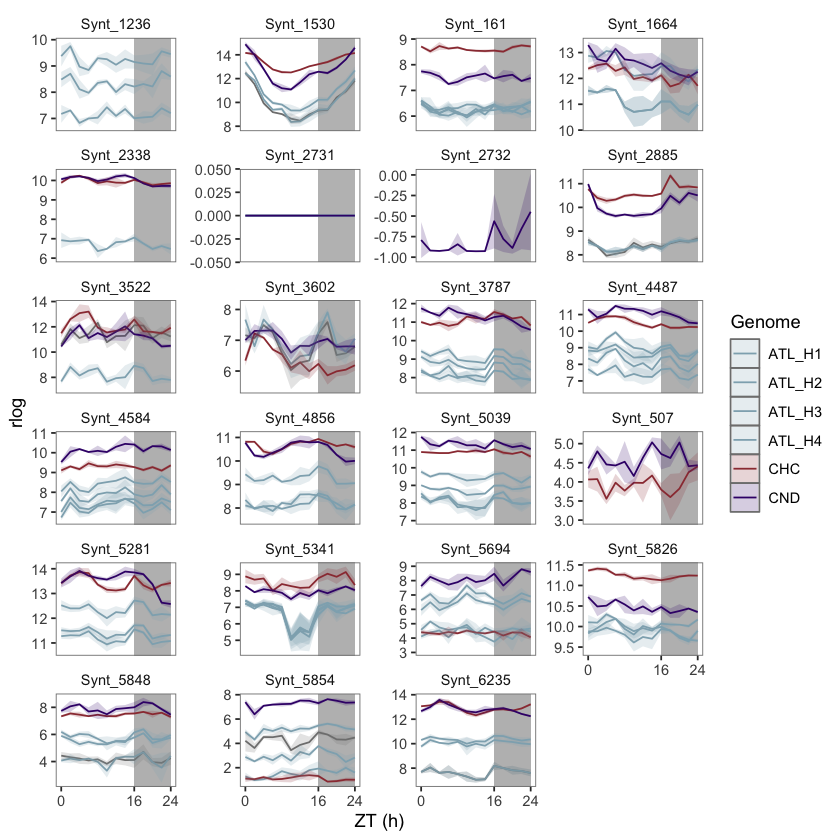

In [25]:
LDL_CHO_Part1 <-StarchGenesExpr %>% 
            filter (Condition == 'LD', Tissue == 'Leaf', Syntelog %in% StarchGenes$Syntelog[1:24] ) %>% 
            LD_ribbon_plot_multiple(.,4)                
LDL_CHO_Part1

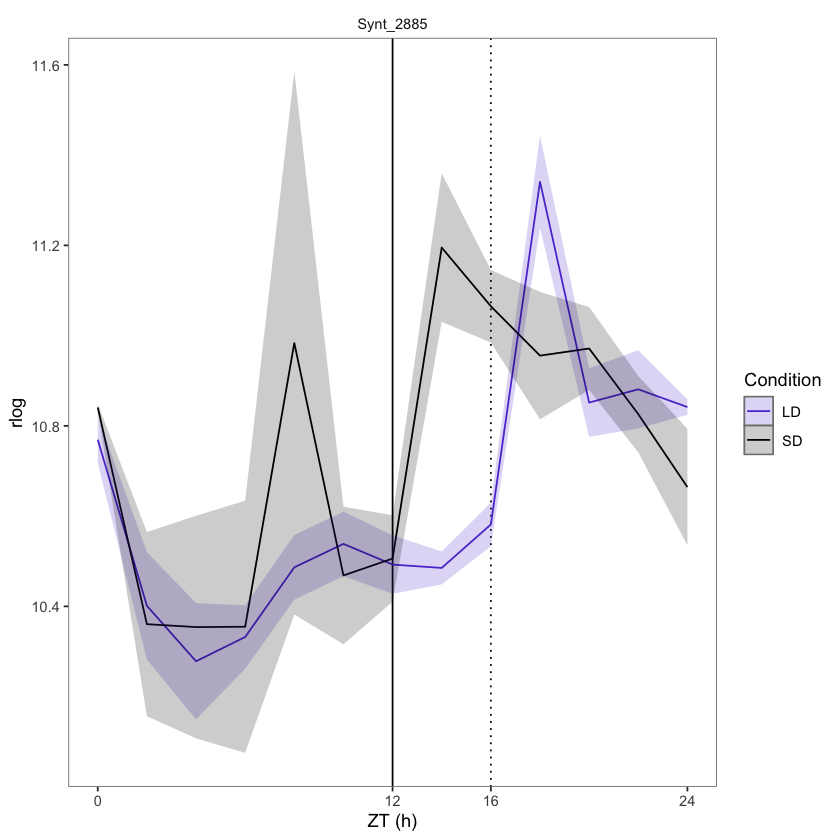

In [24]:
Synt2885<-StarchGenesExpr %>% 
            filter (Genome == 'CHC', Tissue == 'Leaf', Syntelog == 'Synt_2885' ) %>% 
            LDSD_ribbon_plot_multiple(.,3)                
Synt2885


In [30]:
StarchGenesExpr %>% 
            filter (Genome == 'ATL_H2', Tissue == 'Leaf', Syntelog == 'Synt_25639' )

geneID,ZT,Tissue,Condition,mean_expression,std,target_id,Genotype,Syntelog,Genome
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
